# What is this notebook about?
#### In this jupyter notebook you can find a full step by step guide in order to generate the plots presented in the accompanying publication of reference.
These plots are generated mainly to be able to visually inspect the:

    - Number of rounds to convergence (putting an upper bound for cycles).
    - Number of non-manipulable profiles.
    - Quality of winner in truthful vs equilibrium profile. 
        - Definitions:
        - input: one alternative `a` and one truthful profile. 
        - For every voter, look at her preference. The quality of the alternative a is #1s - #(-1s) in the row of `a`. Sum up the quality of a for all voters. This is the social welfare. Calculate social welfare for truthful winner and convergence winner, and subtract latter from former.
    - Number of times where the winner was the same as the truthful one

In [1]:
import os

import dill
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from main.data_processing import evaluate_profile, get_social_welfare_of_alternative

In [2]:
def calculate_qualities_of_winners(input_data, df_result, k, method):
    """
    input_data: list of profiles
    df_result: processed dataframe with the results
    """
    num_alt = len(input_data[0][0])
    alph_order = {}
    for i in range(num_alt):
        alph_order[i] = i

    winners = df_result['result'].apply(lambda d: d[max(d.keys())][0] if d else None).values
    same_winner_times = 0
    qualities = []
    for i in range(len(winners)):
        if not pd.isnull(winners[i]):
            true_win = evaluate_profile(input_data[i], k, method, alph_order)[0]
            if true_win == winners[i]:
                same_winner_times += 1
            qualities.append(
                get_social_welfare_of_alternative(input_data[i], winners[i]) - get_social_welfare_of_alternative(
                    input_data[i], true_win))
    return qualities, same_winner_times


def get_qualities_of_winners(completeness, d_type, num_vot, num_alt, method, k, qualities_of_winners, input_data, dft):
    if (completeness, d_type, num_vot, num_alt, method, k) not in qualities_of_winners.keys():
        qualities, same_winner_times = calculate_qualities_of_winners(input_data[(num_vot, num_alt, d_type)], dft, k,
                                                                      method)
        qualities_of_winners[(completeness, d_type, num_vot, num_alt, method, k)] = (qualities, same_winner_times)
        with open('data/results/qualities_of_winners.pkl', 'wb') as f:
            dill.dump(qualities_of_winners, f)
    else:
        qualities, same_winner_times = qualities_of_winners[(completeness, d_type, num_vot, num_alt, method, k)]
    return qualities, same_winner_times

# Data load and set-up

In [3]:
with open('data/results/total_result.pkl', 'rb') as f:
    total_result = dill.load(f)

## Calculate quality of winners

In [4]:
with open('data/our_data_complete.pkl', 'rb') as f:
    input_data_complete = dill.load(f)
with open('data/our_data_incomplete.pkl', 'rb') as f:
    input_data_incomplete = dill.load(f)

In [5]:
data_df = pd.DataFrame(total_result).T
data_df.columns = ['convergence', 'result']

In [6]:
if os.path.isfile('data/results/qualities_of_winners.pkl'):
    with open('data/results/qualities_of_winners.pkl', 'rb') as f:
        qualities_of_winners = dill.load(f)
else:
    qualities_of_winners = {}

In [7]:
inds = []
convergence_rounds_all = {}
qualities_all = {}
same_winner_times_all = {}

for completeness in [True, False]:
    for num_alt in [3, 4, 5]:
        for d_type in ["2urn", "ic"]:
            for num_vot in [10, 20, 50]:
                for method in ['approval', 'veto']:
                    for k in [1, num_alt - 1]:  # [1, num_alt-1]
                        try:
                            dft = data_df.loc[
                                (num_alt, num_vot, d_type, slice(None), k, method, 0, True, True, True, completeness)]
                            convergence_rounds = dft['result'].apply(lambda d: max(d.keys()) + 1 if d else 0)
                            input_data = {True: input_data_complete, False: input_data_incomplete}[completeness]

                            qualities, same_winner_times = get_qualities_of_winners(completeness, d_type, num_vot,
                                                                                    num_alt, method, k,
                                                                                    qualities_of_winners, input_data,
                                                                                    dft)

                            inds.append((num_alt, num_vot, d_type, completeness, method, k))
                            idx = inds[-1]
                            convergence_rounds_all[idx] = convergence_rounds
                            qualities_all[idx] = pd.Series(qualities)
                            same_winner_times_all[idx] = same_winner_times

                            print(
                                f'k: {k}, {method}, num_alt: {num_alt}, num_vot: {num_vot}, d_type: {d_type}: percent of converged {dft["convergence"].max() * 100}%, convergence rounds: mean={convergence_rounds.mean()}, max={convergence_rounds.max()}, std={convergence_rounds.std():.2f}, mean_quality: {np.mean(qualities):.2f}, times with no winner change: {same_winner_times}')
                        except KeyError:
                            pass

k: 1, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.325, max=10, std=1.04, mean_quality: 0.26, times with no winner change: 8
k: 2, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.615, max=7, std=1.24, mean_quality: 0.94, times with no winner change: 20
k: 1, veto, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=1.59, max=29, std=3.38, mean_quality: 2.07, times with no winner change: 31
k: 2, veto, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.255, max=3, std=0.67, mean_quality: 0.39, times with no winner change: 8
k: 1, approval, num_alt: 3, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.27, max=5, std=0.85, mean_quality: 1.91, times with no winner change: 11
k: 2, approval, num_alt: 3, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence r

<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, approval, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=2.565, max=29, std=4.74, mean_quality: 0.83, times with no winner change: 27
k: 1, veto, num_alt: 5, num_vot: 50, d_type: ic: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0
k: 4, veto, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=5.945, max=29, std=9.86, mean_quality: 4.73, times with no winner change: 30
k: 1, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.09, max=3, std=0.38, mean_quality: 1.23, times with no winner change: 2
k: 2, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.915, max=7, std=1.42, mean_quality: 3.08, times with no winner change: 27
k: 1, veto, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean

k: 4, approval, num_alt: 5, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=11.56, max=34, std=6.33, mean_quality: 3.81, times with no winner change: 52
k: 1, veto, num_alt: 5, num_vot: 20, d_type: ic: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0
k: 4, veto, num_alt: 5, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=4.775, max=14, std=4.28, mean_quality: 4.46, times with no winner change: 59
k: 1, approval, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=1.535, max=13, std=2.87, mean_quality: 3.16, times with no winner change: 32
k: 4, approval, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=27.16, max=65, std=19.85, mean_quality: 2.97, times with no winner change: 46
k: 1, veto, num_alt: 5, num_vot: 50, d_type: ic: percent of converged nan%, convergence rounds: mean=

# Plots

The different kind of plots we 're interested in creating are mentioned below and they have in their x & y axis repsectively:

1. x: number of rounds ; y: percentage of profiles that have converged for this x
each plot includes: ic,2urn,complete,incomplete. Different plots for (n,m) (n: voters, m: alternatives)

2. x: indices (n, m, ic, 2urn, complete, incomplete) ; y: percentage of non-manipulable profiles

3. x: quality of winner; y: percentage of profiles that have that quality of winner
each plot includes: ic,2urn,complete,incomplete. Different plots for (n,m) 

4. x: indices (n, m, ic, 2urn, complete, incomplete) ; y: percentage of profiles with true winner

## 1.

In [13]:
df = pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']

In [14]:
df = df[df['result'] != 0]
df = df[df['result'] < 50]

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


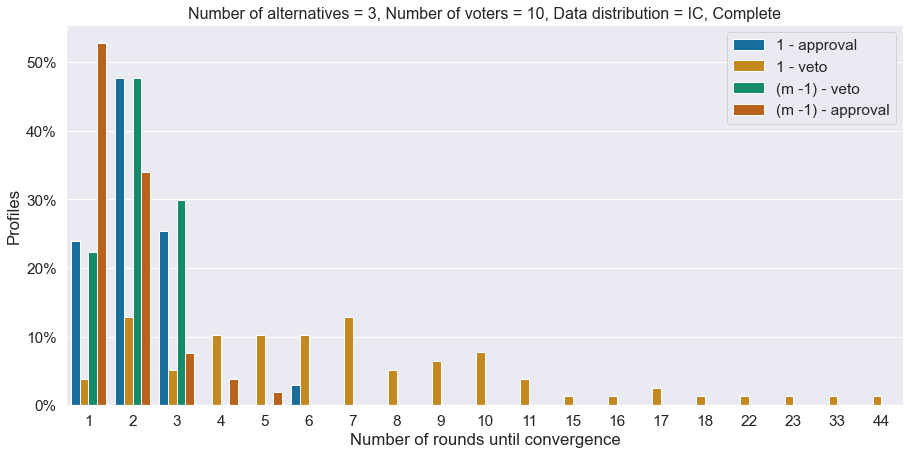

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


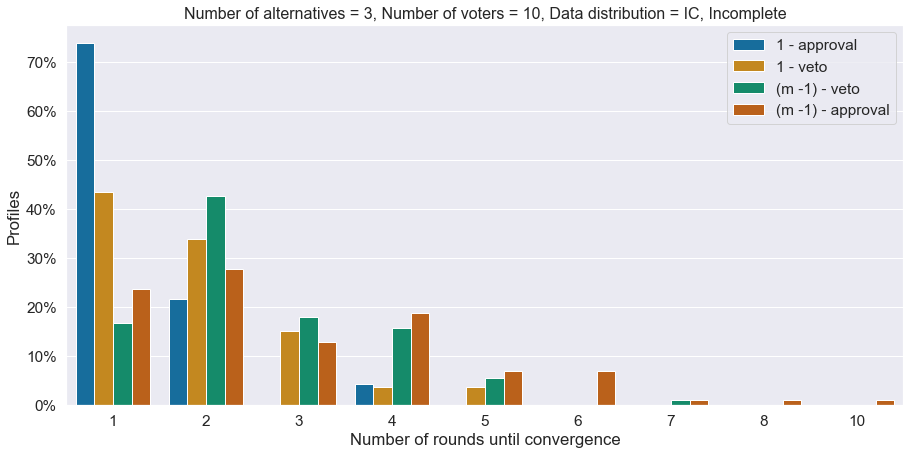

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


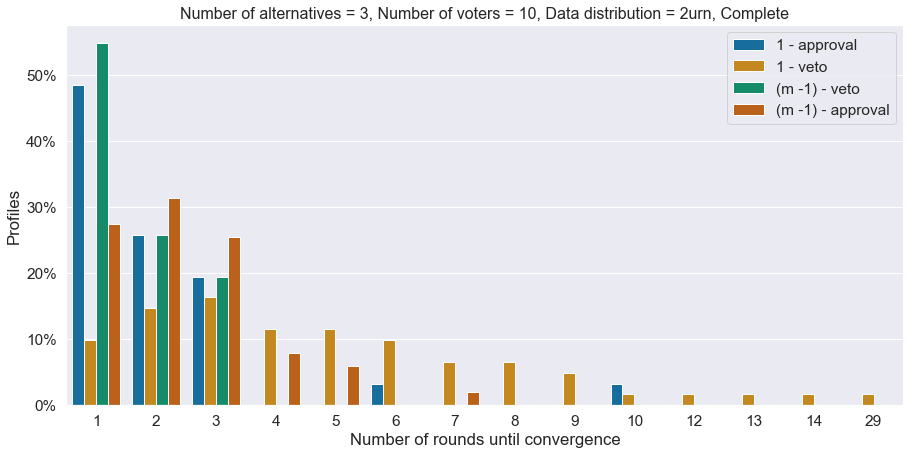

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


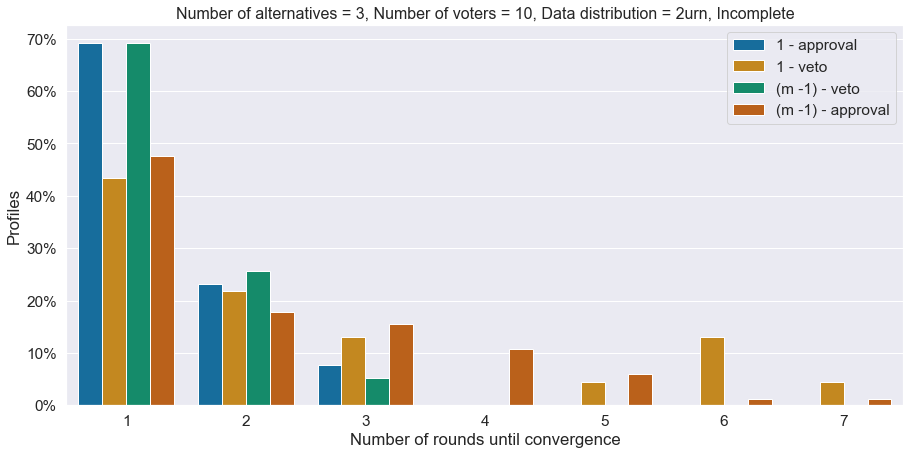

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


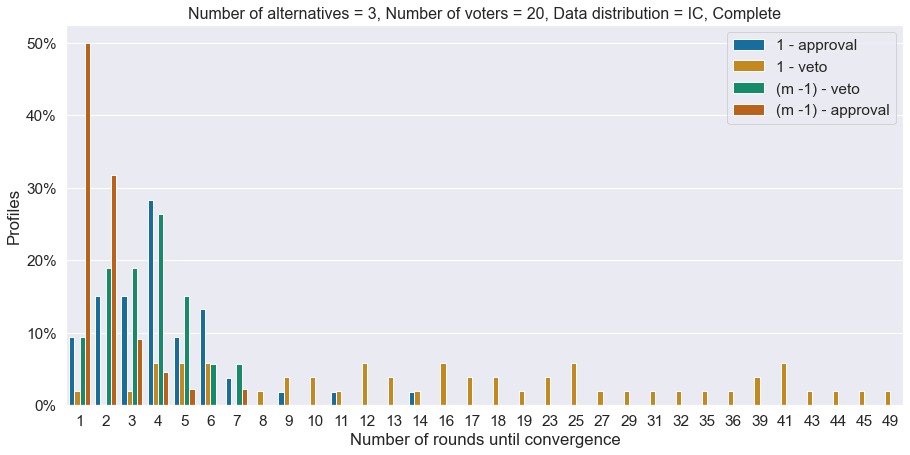

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


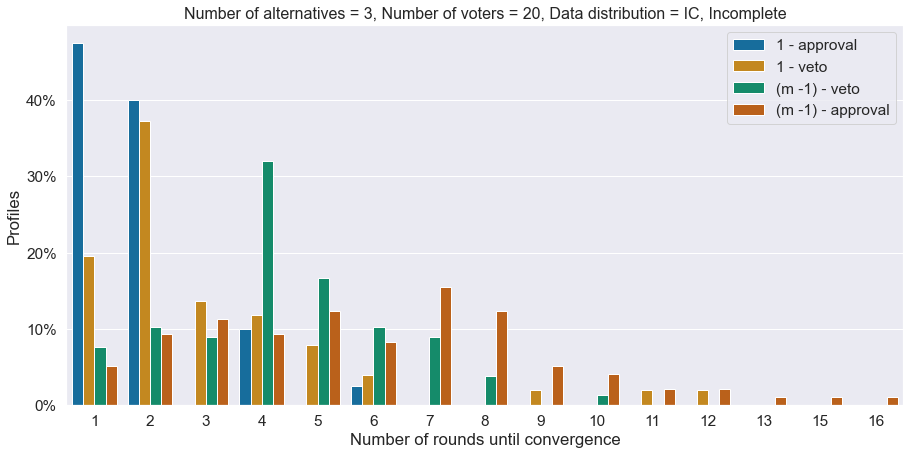

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


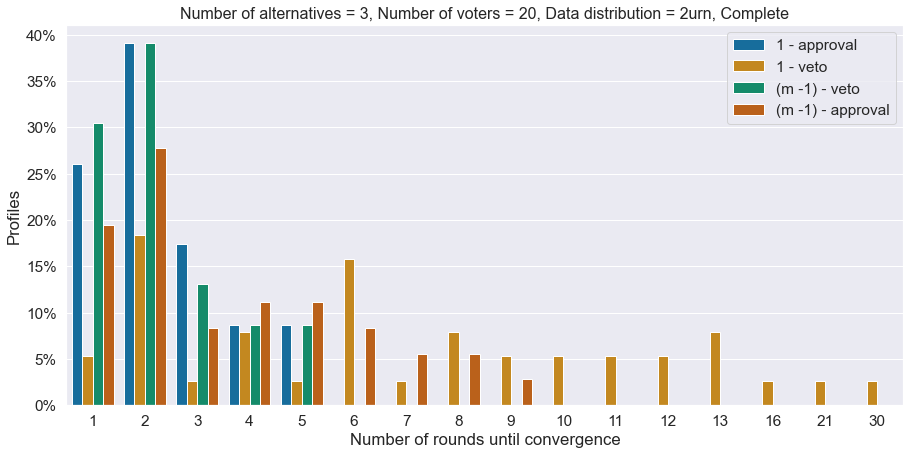

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


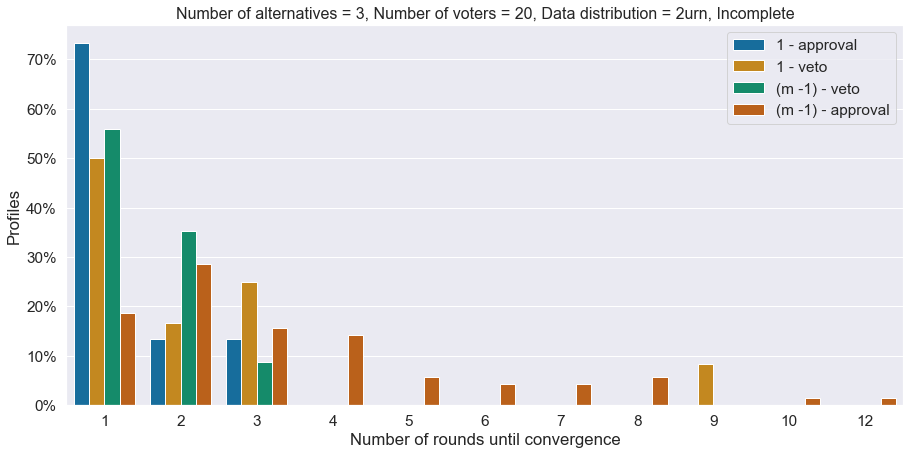

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


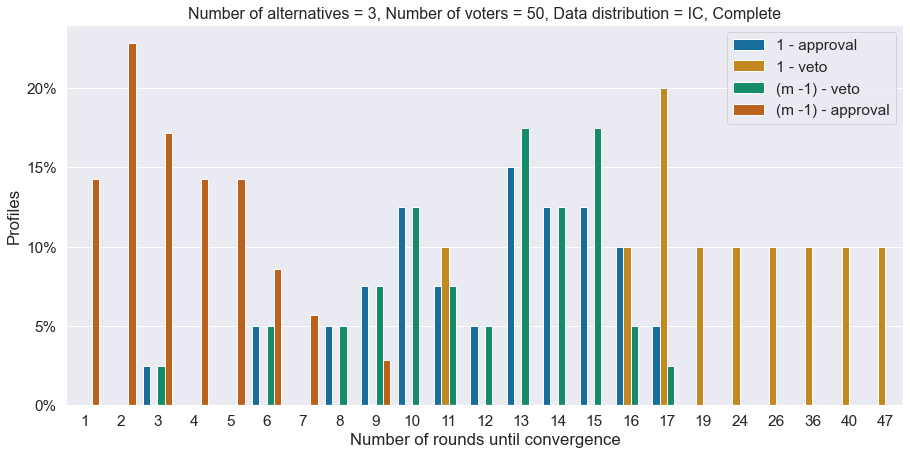

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


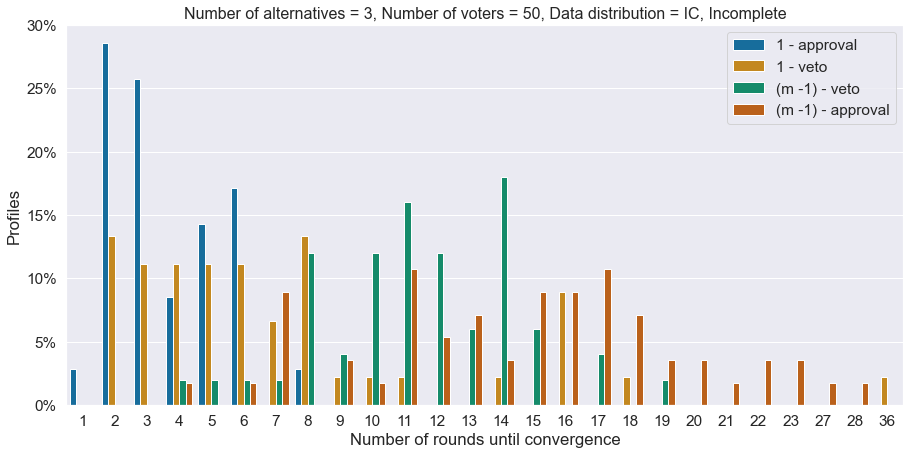

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


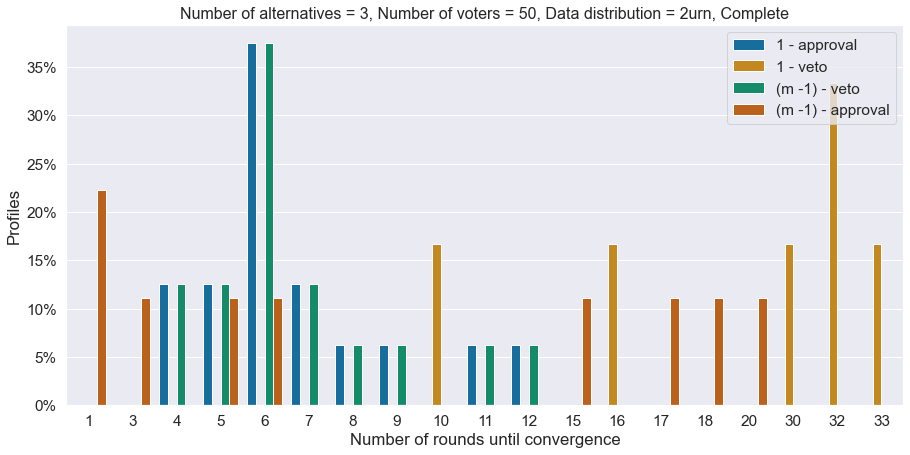

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


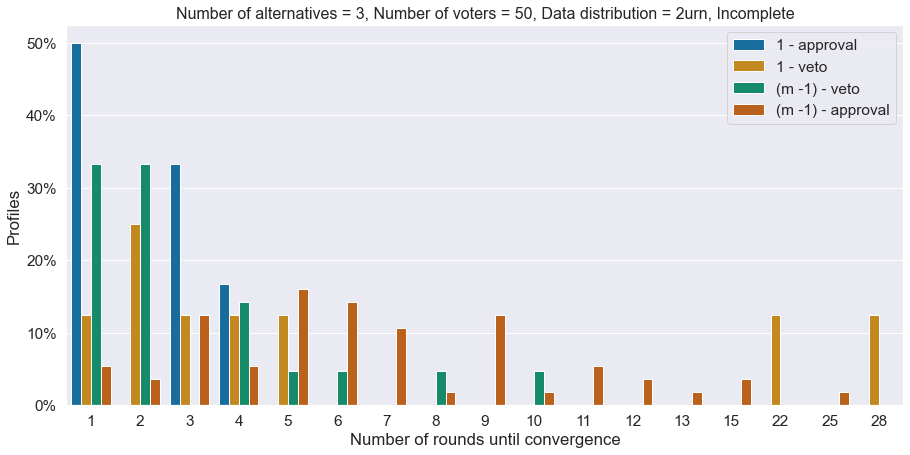

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


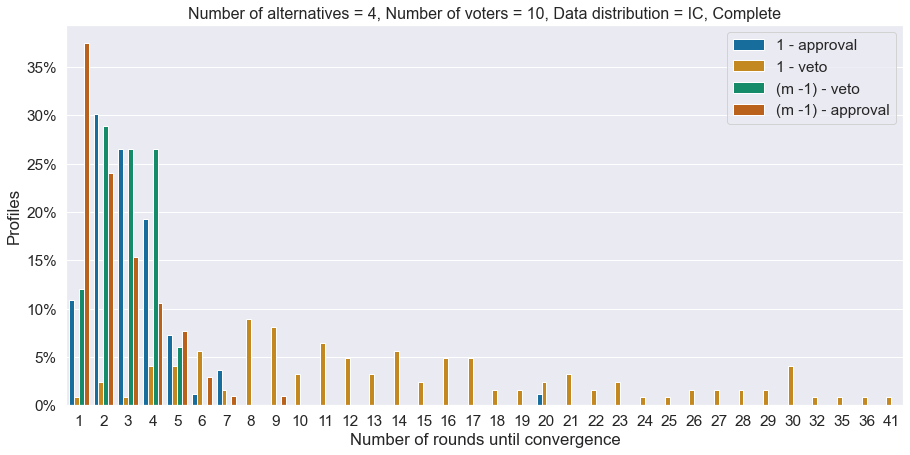

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


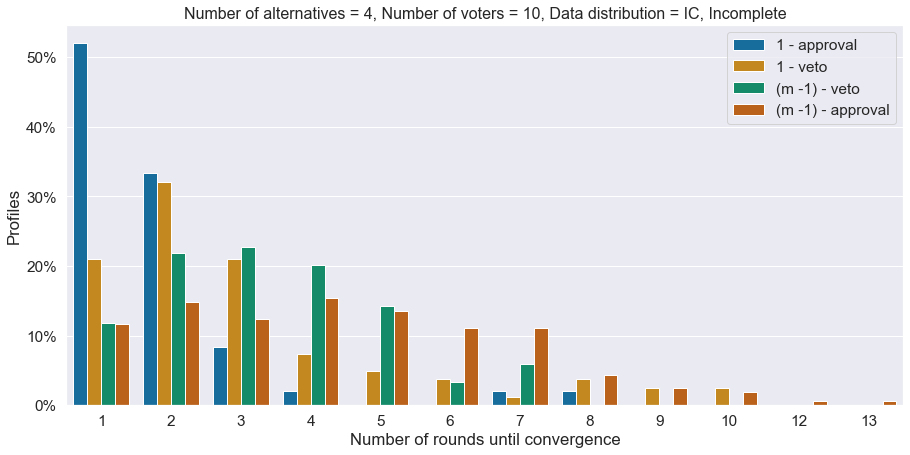

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


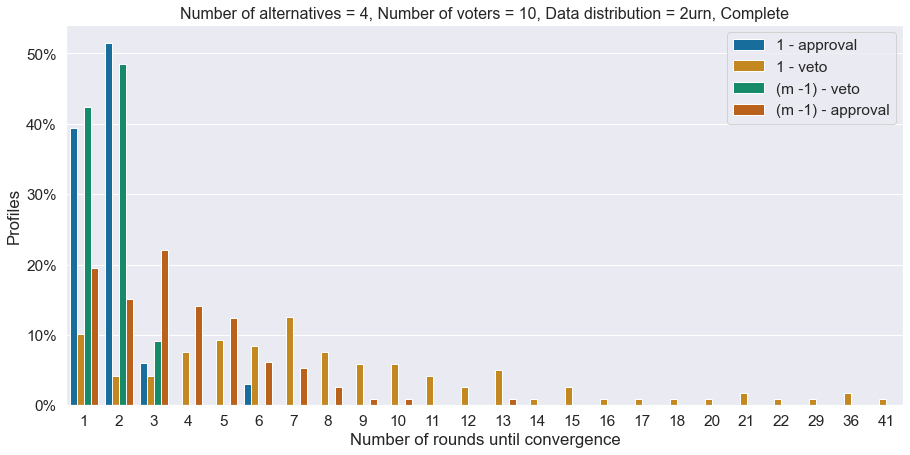

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


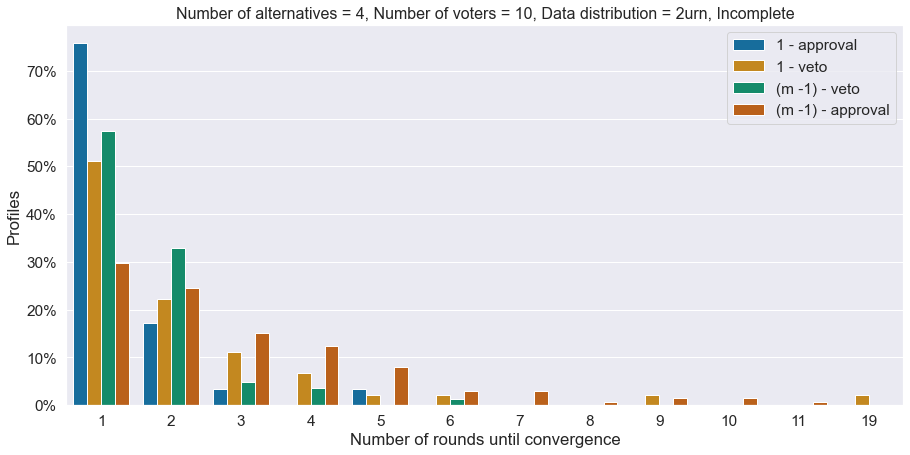

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


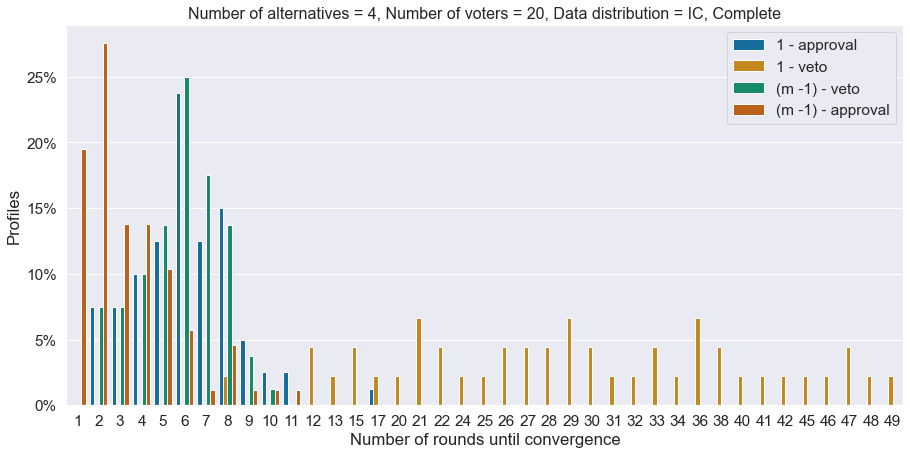

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


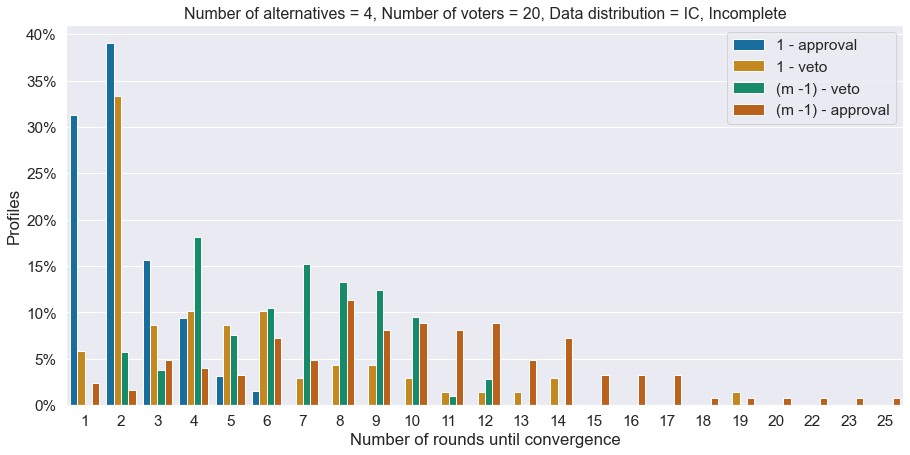

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


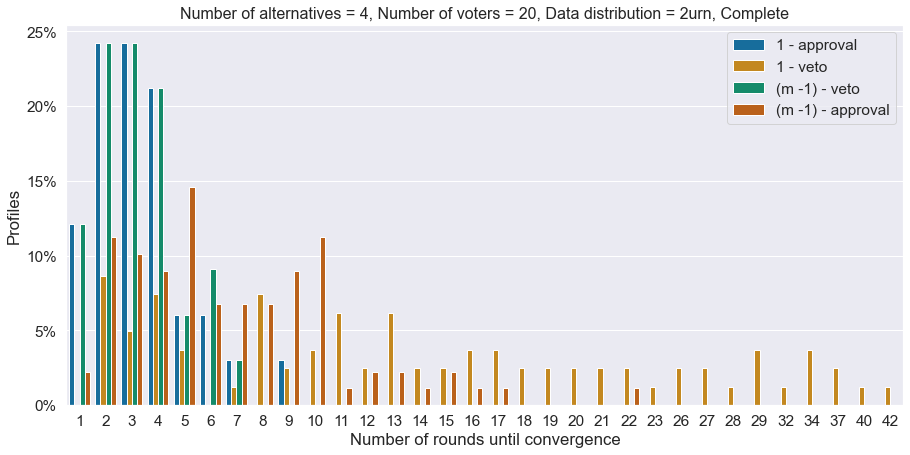

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


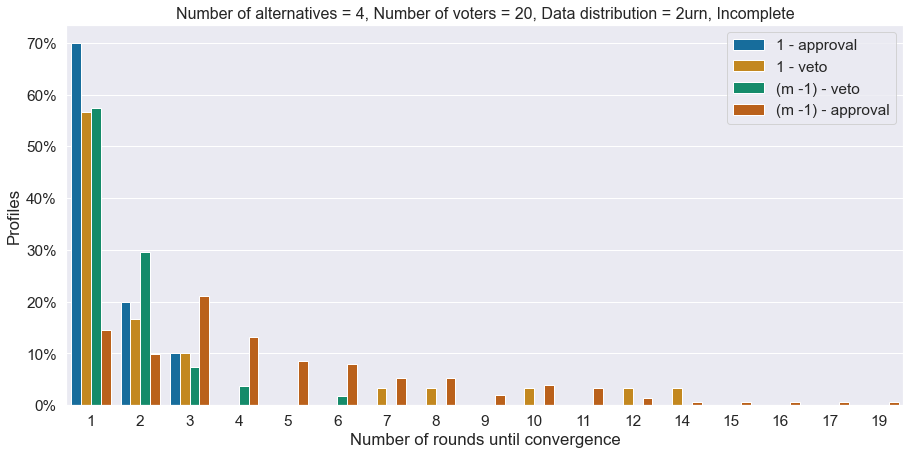

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


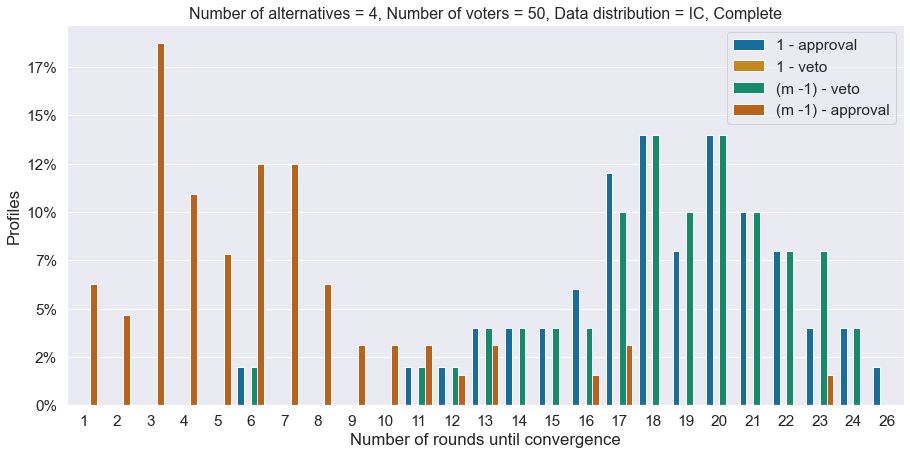

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


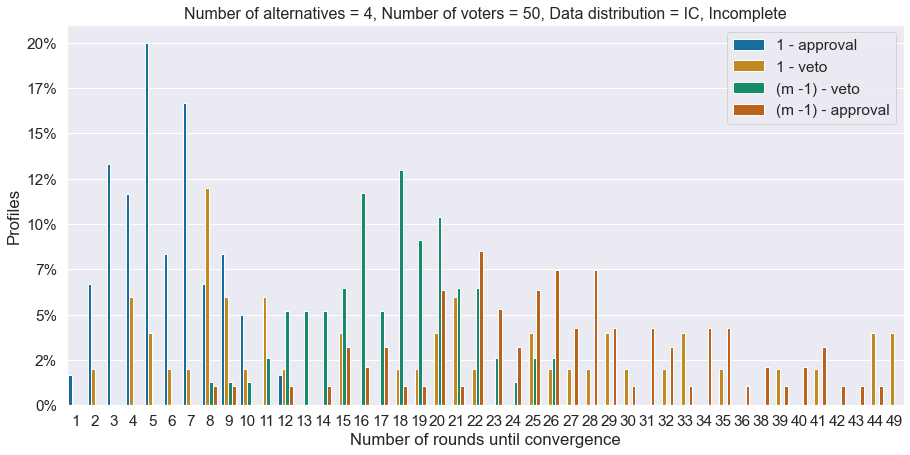

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


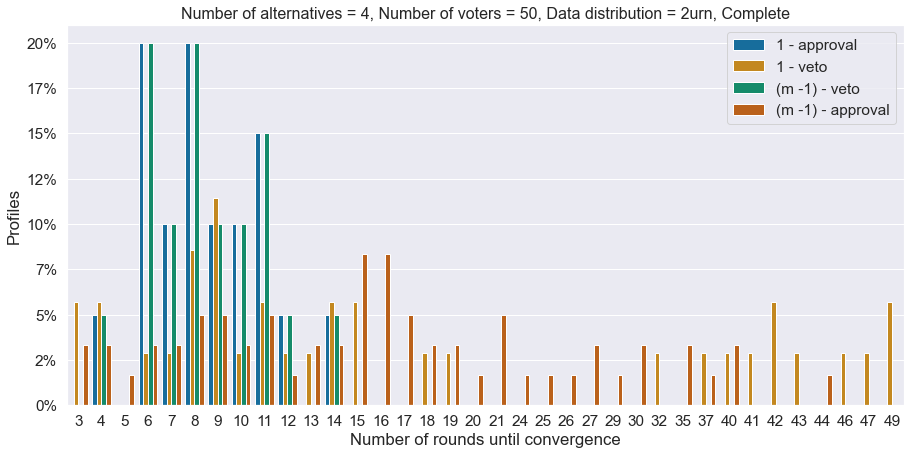

<ipython-input-22-4d9359f73ba1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


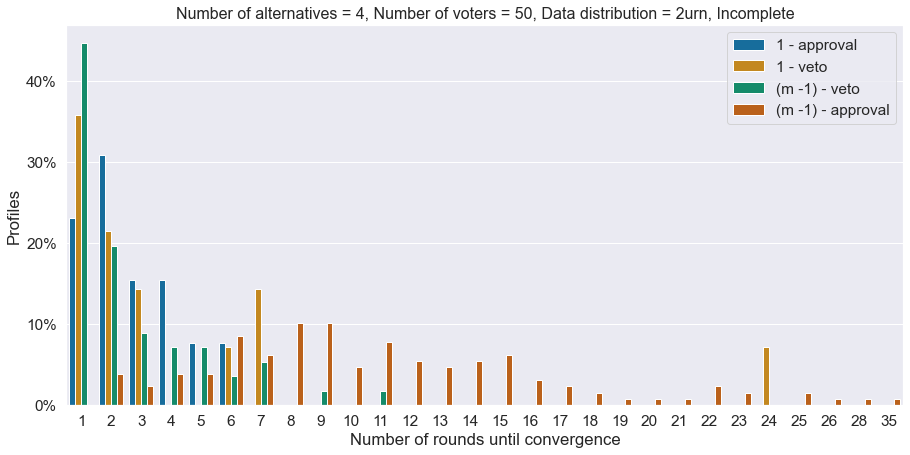

In [22]:
for num_alt in [3, 4]:
    for num_vot in [10, 20, 50]:
        for data_type in ['ic', '2urn']:
            for completeness in [True, False]:
                comp = {True: 'Complete', False: 'Incomplete'}[completeness]
                dft = df.loc[(num_alt, num_vot, data_type, completeness, slice(None), slice(None))]
                dft.reset_index(inplace=True)
                dft = dft.groupby(['method', 'k']).apply(
                    lambda df: df['result'].value_counts(normalize=True)).reset_index()
                dft.rename(columns={'level_2': 'Number of rounds until convergence', 'result': 'Profiles'},
                           inplace=True)
                dft['Profiles'] = dft['Profiles'] * 100

                dft['k'] = dft['k'].apply(lambda x: '1' if x == 1 else 'num_alt-1')
                dft['Rule'] = dft.apply(lambda row: (f'{row["k"].replace("num_alt-1", "(m -1)")} - {row["method"]}'),
                                        axis=1)

                sns.set(rc={'figure.figsize': (15, 7)})
                sns.set(font_scale=1.4)
                g = sns.barplot(data=dft,
                                x='Number of rounds until convergence',
                                y='Profiles',
                                hue='Rule',
                                palette="colorblind",
                                hue_order=['1 - approval', '1 - veto', '(m -1) - veto', '(m -1) - approval'])
                d_type2show = 'IC' if data_type == 'ic' else data_type
                plt.title(
                    f'Number of alternatives = {num_alt}, Number of voters = {num_vot}, Data distribution = {d_type2show}, {comp}',
                    fontsize=16)
                plt.legend(loc='upper right')
                ylabels = [str(int(x)) + '%' for x in g.get_yticks()]
                g.set_yticklabels(ylabels)
                plt.show()

## 2.

In [29]:
df = pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)

In [30]:
df = pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']
df.reset_index(inplace=True)
df['data_type'] = df['data_type'].apply(lambda x: 'IC' if x == 'ic' else x)

df['k'] = df['k'].apply(lambda x: '1' if x == 1 else 'num_alt-1')

<ipython-input-33-d53300d95487>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
<ipython-input-33-d53300d95487>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


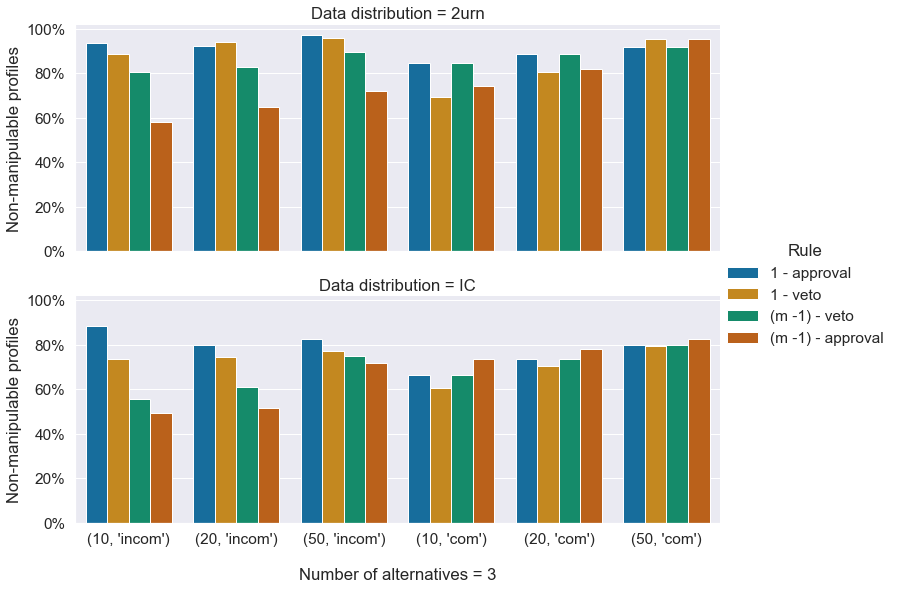

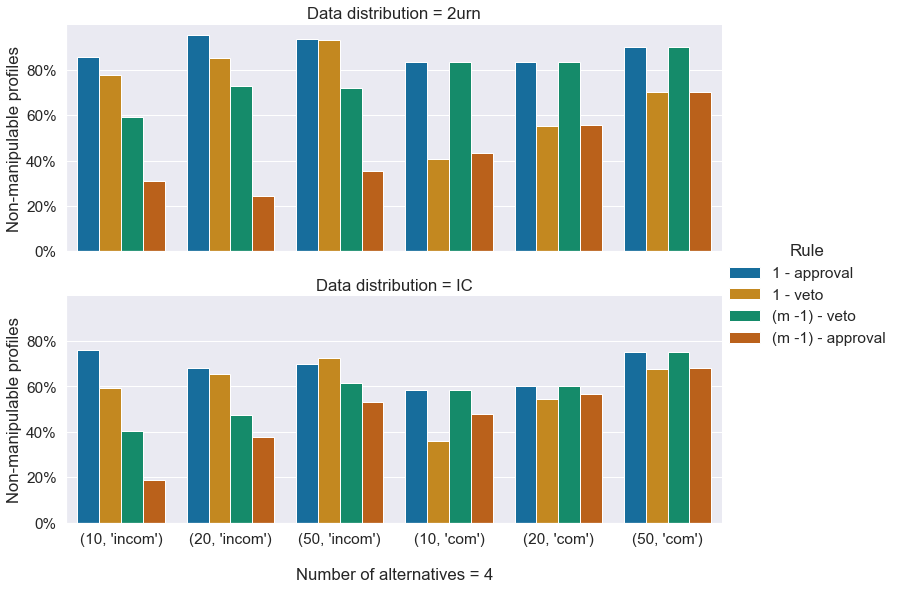

In [33]:
for num_alt_to_show in [3, 4]:
    dft = df[df['num_alt'] == num_alt_to_show]

    dft = dft.groupby(['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']).apply(
        lambda x: (x['result'] == 0).sum() / len(x)).reset_index()
    dft.rename(columns={0: 'Non-manipulable profiles', 'data_type': 'Data distribution'}, inplace=True)
    dft['Non-manipulable profiles'] = dft['Non-manipulable profiles'] * 100
    dft[f'\nNumber of alternatives = {num_alt_to_show}'] = dft.apply(
        lambda row: (row["num_vot"], {True: 'com', False: 'incom'}[row["completeness"]]), axis=1)
    dft['Rule'] = dft.apply(lambda row: (f'{row["k"].replace("num_alt-1", "(m -1)")} - {row["method"]}'), axis=1)

    sns.set(font_scale=1.4)
    g = sns.catplot(x=f'\nNumber of alternatives = {num_alt_to_show}',
                    y='Non-manipulable profiles',
                    hue="Rule",
                    row='Data distribution',
                    data=dft,
                    kind="bar",
                    order=[(10, 'incom'), (20, 'incom'), (50, 'incom'), (10, 'com'), (20, 'com'), (50, 'com')],
                    hue_order=['1 - approval', '1 - veto', '(m -1) - veto', '(m -1) - approval'],
                    height=4, aspect=2.5, palette='colorblind')

    for ax in g.axes.flat:
        ylabels = [str(int(x)) + '%' for x in ax.get_yticks()]
        ax.set_yticklabels(ylabels)


## 3.

In [24]:
df = pd.DataFrame(pd.concat(qualities_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']
df.rename(columns={0: 'qualities'}, inplace=True)

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


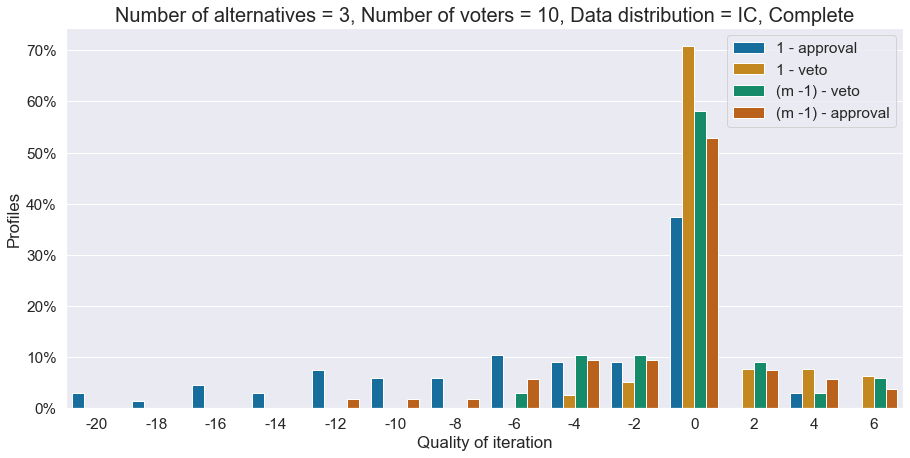

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


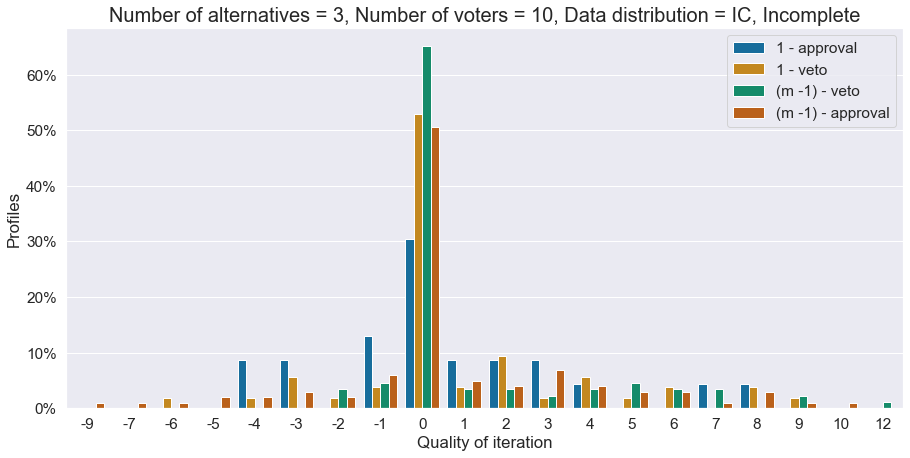

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


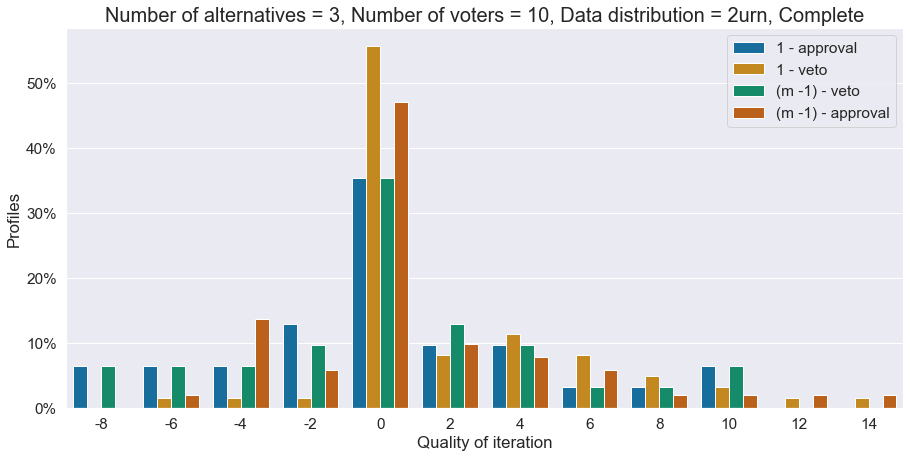

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


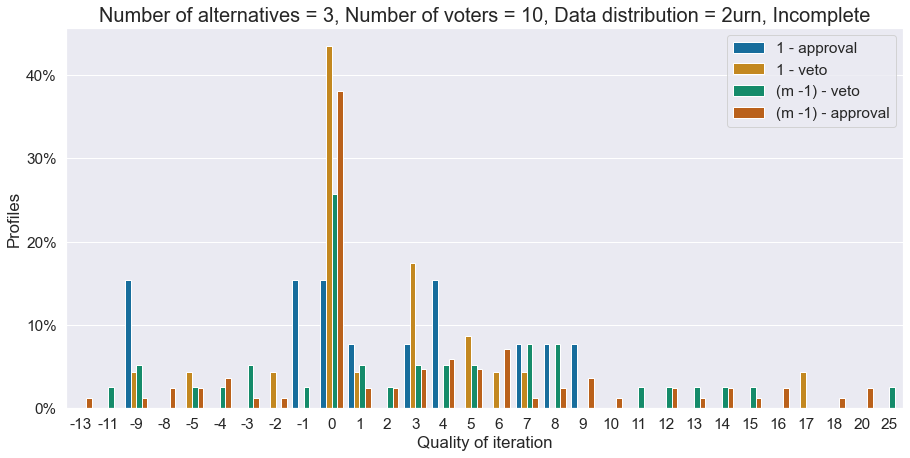

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


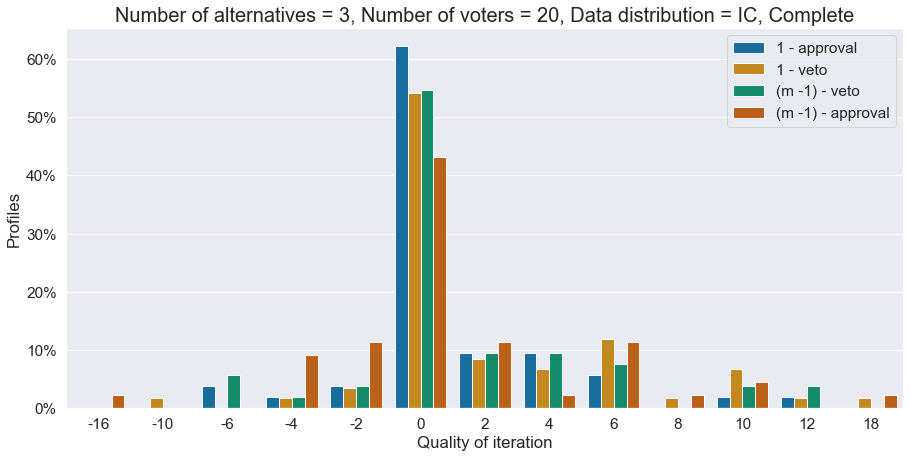

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


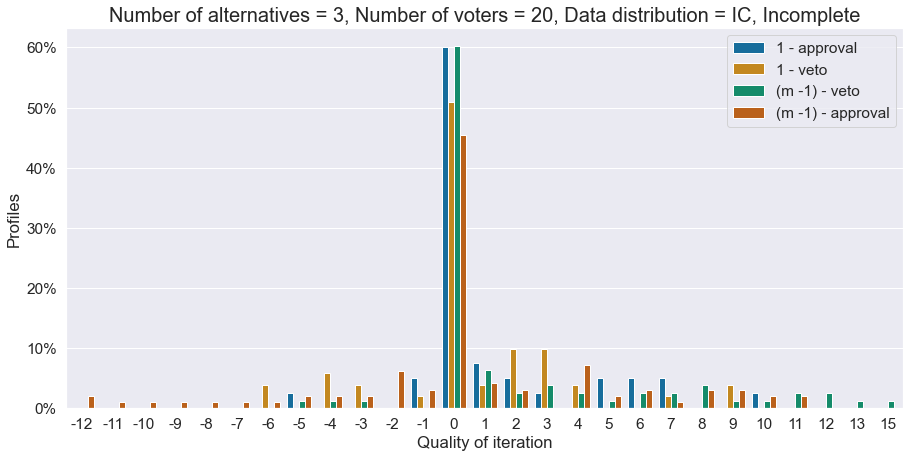

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


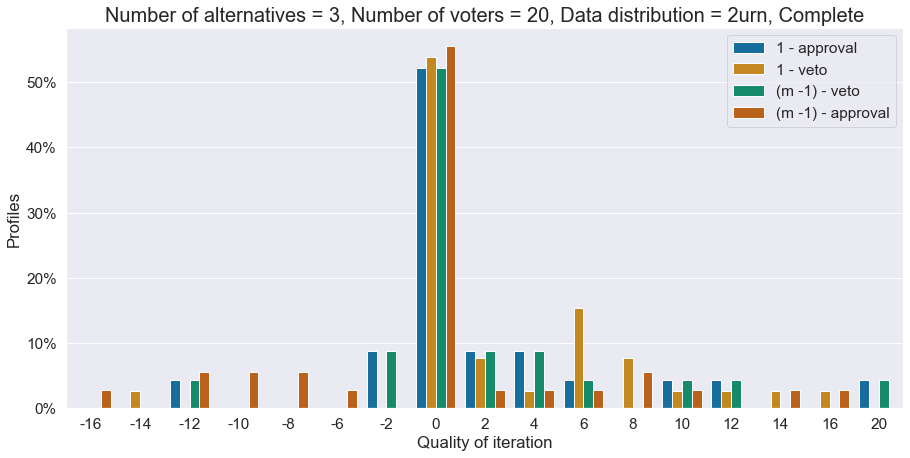

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


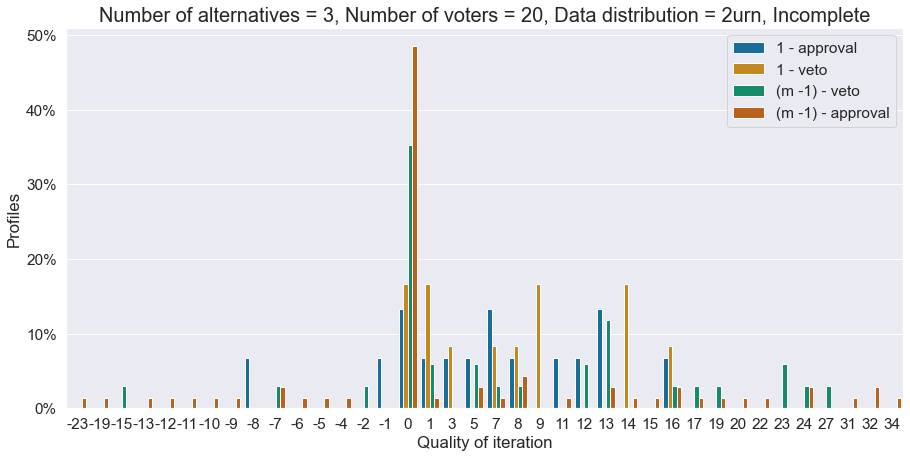

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


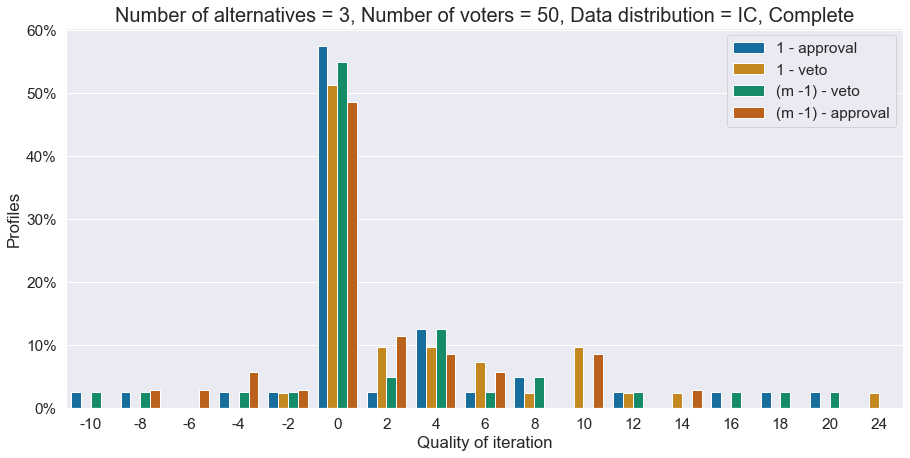

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


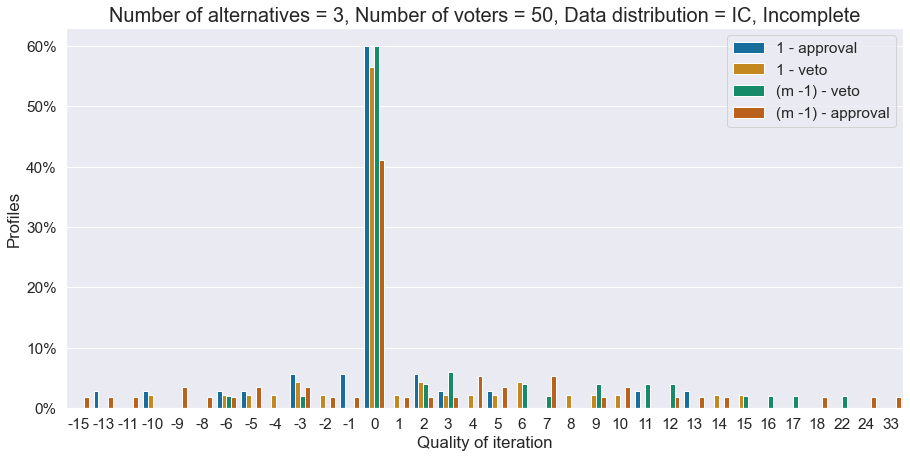

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


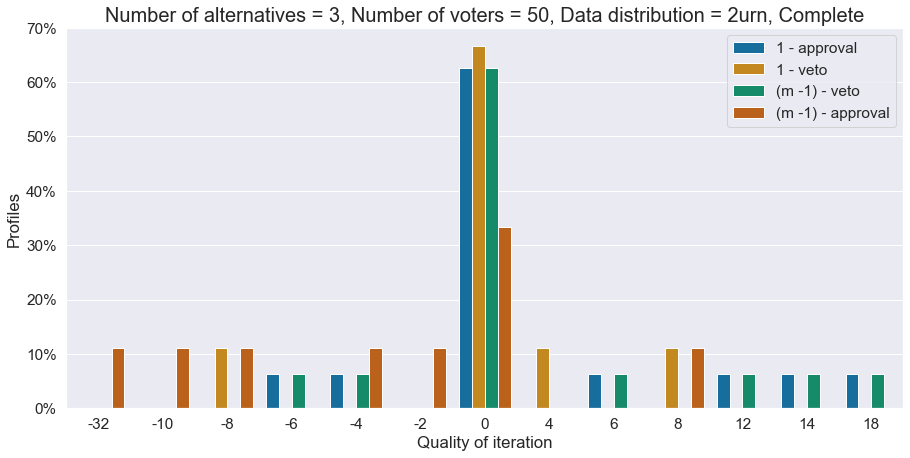

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


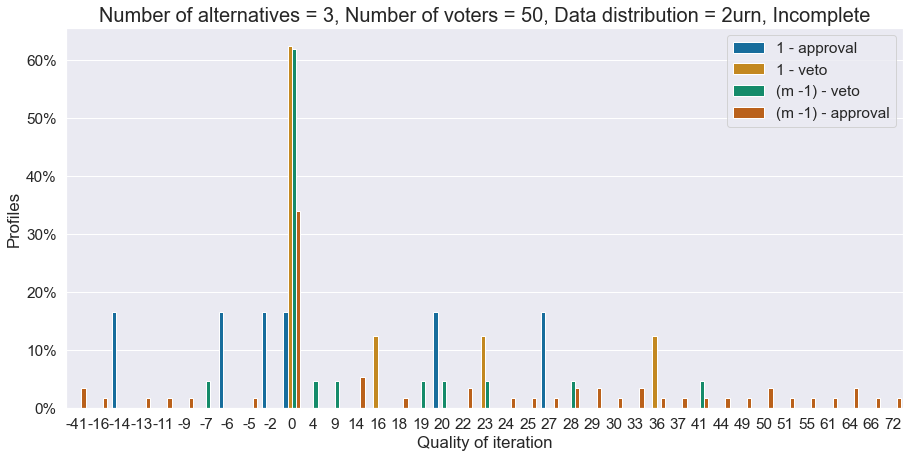

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


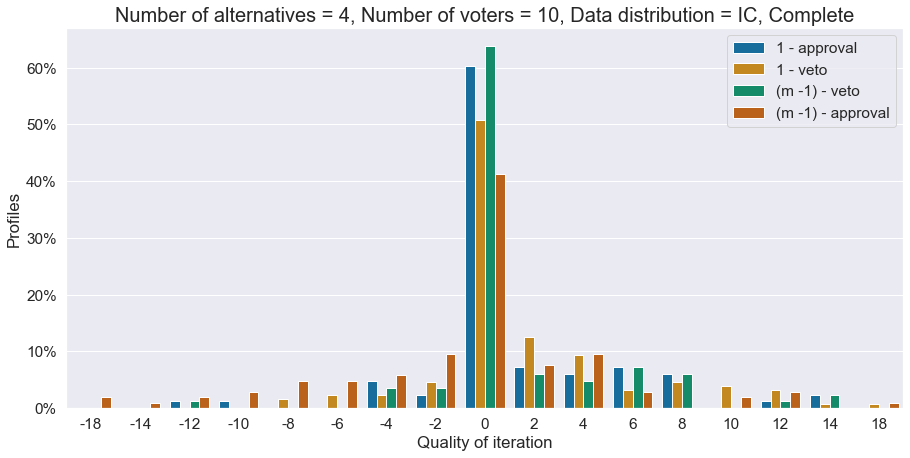

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


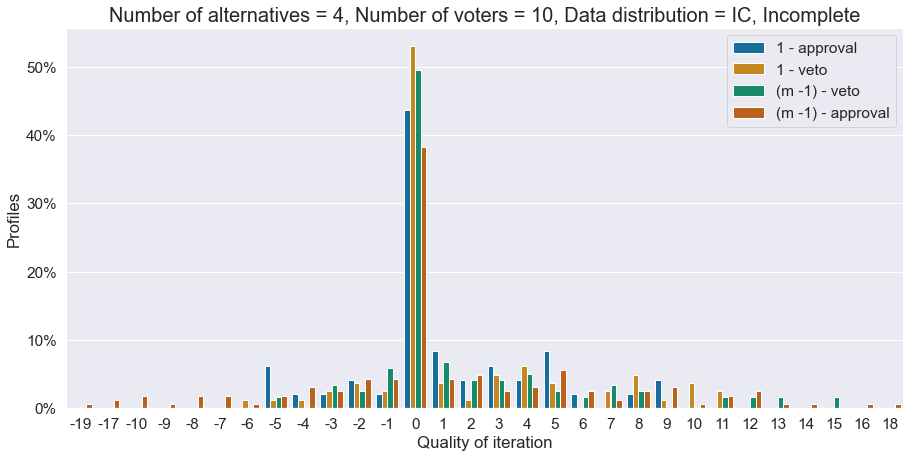

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


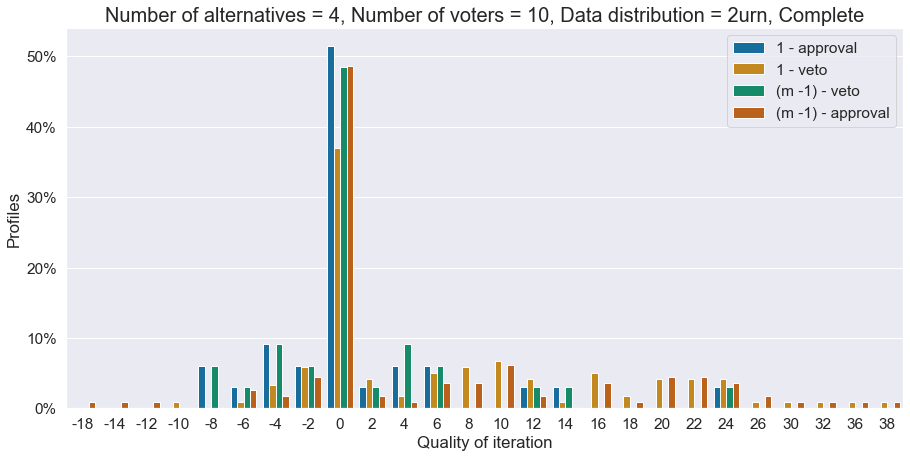

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


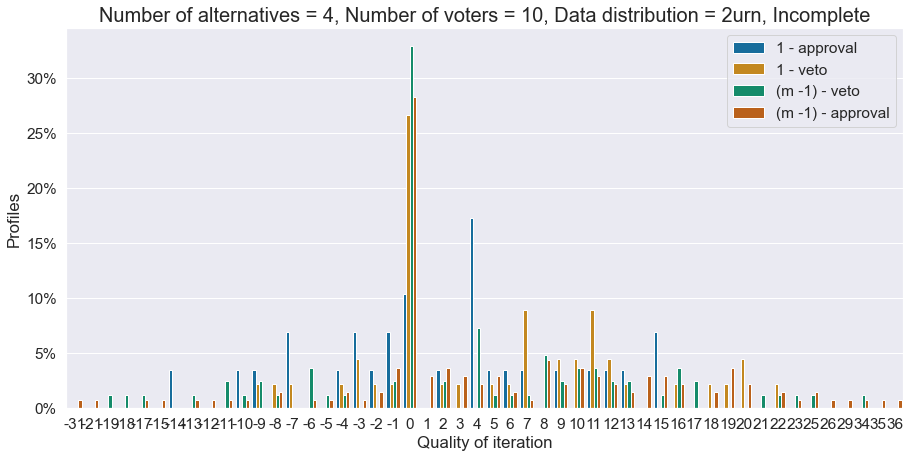

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


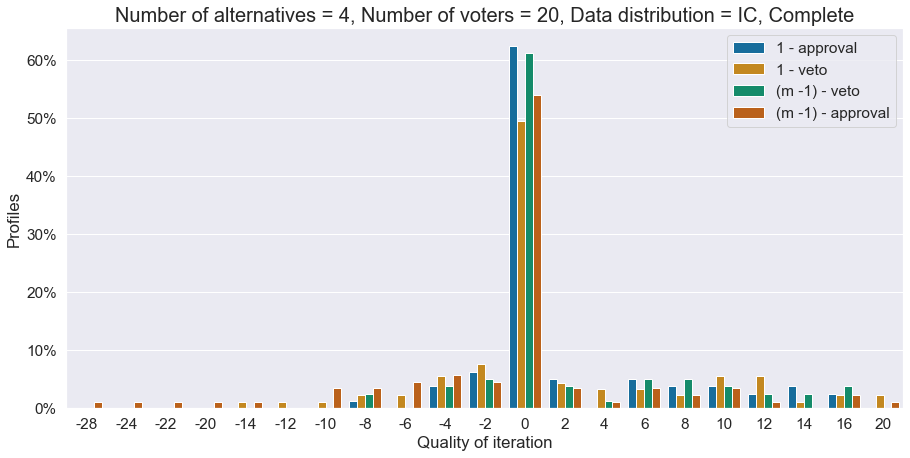

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


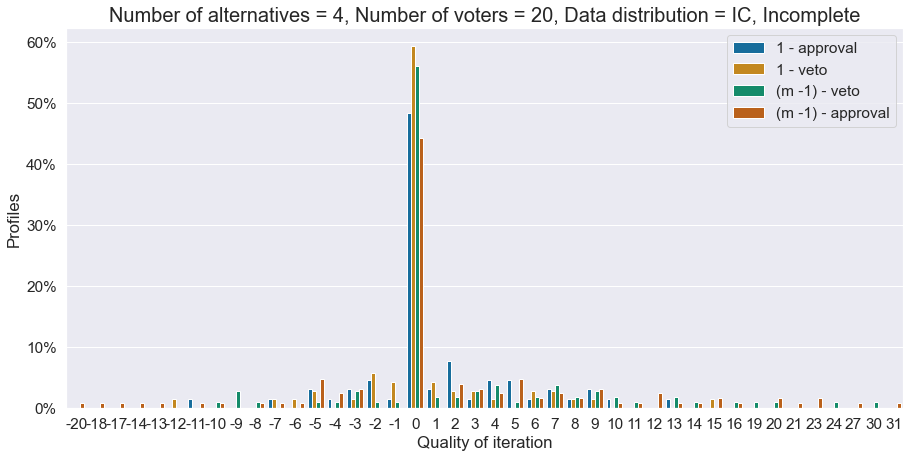

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


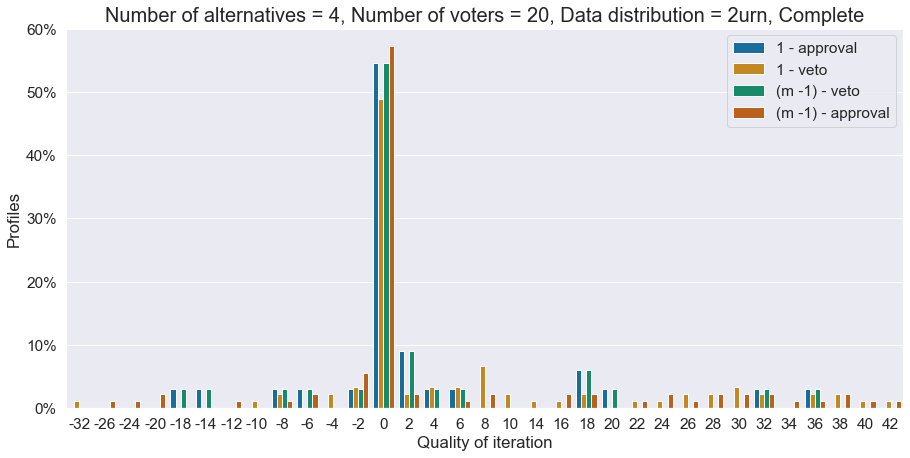

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


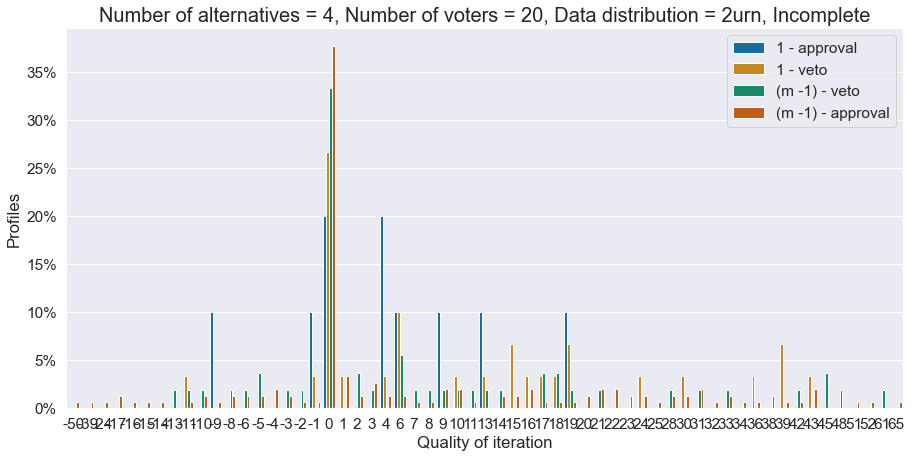

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


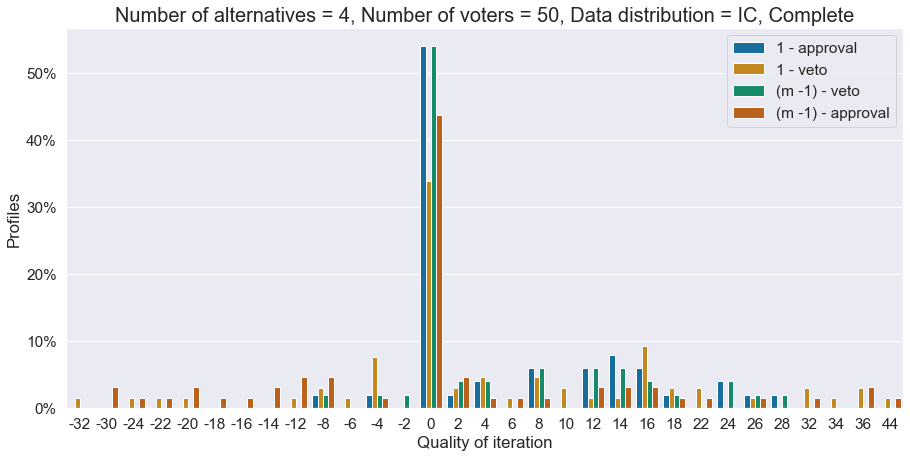

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


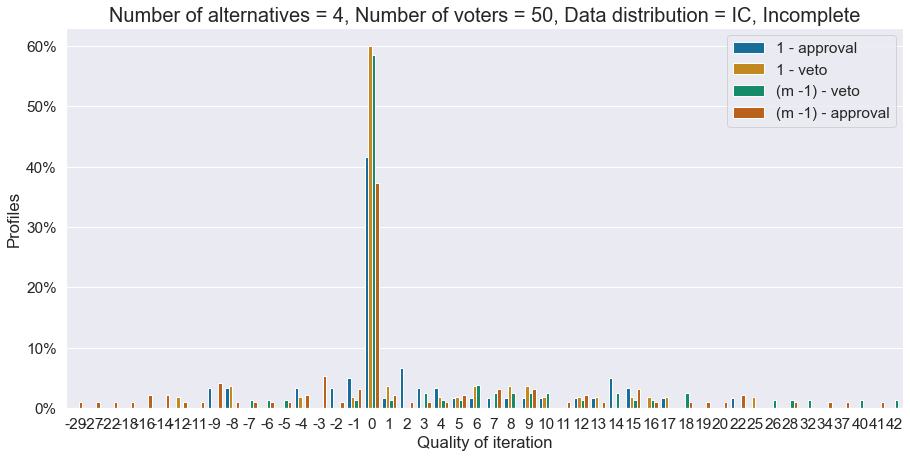

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


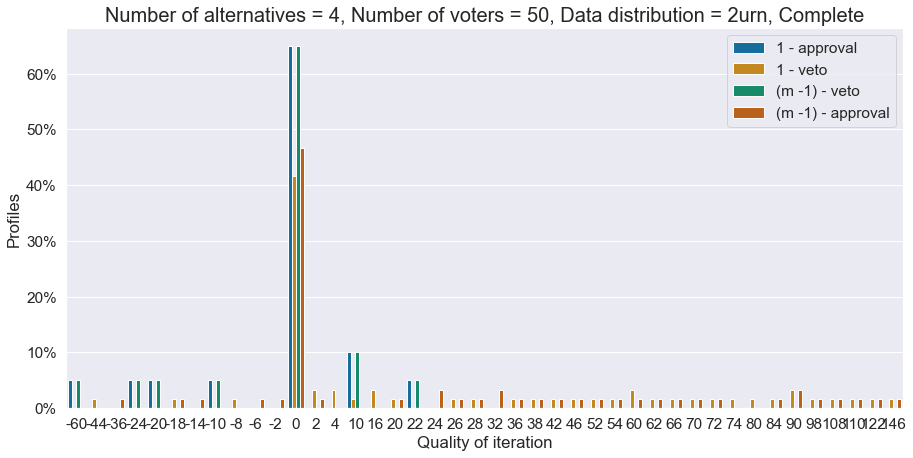

<ipython-input-26-2670b299e963>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


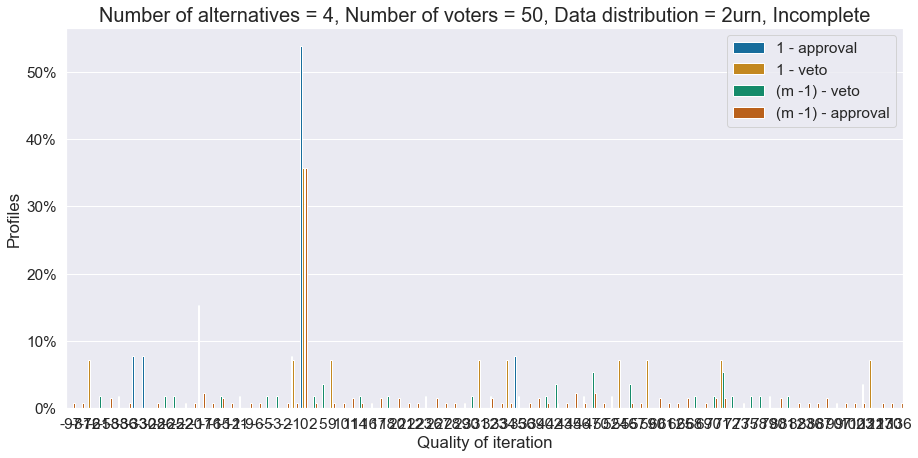

In [26]:
for num_alt in [3, 4]:
    for num_vot in [10, 20, 50]:
        for data_type in ['ic', '2urn']:
            for completeness in [True, False]:
                comp = {True: 'Complete', False: 'Incomplete'}[completeness]
                dft = df.loc[(num_alt, num_vot, data_type, completeness, slice(None), slice(None))]
                dft.reset_index(inplace=True)
                dft = dft.groupby(['method', 'k']).apply(
                    lambda df: df['qualities'].value_counts(normalize=True)).reset_index()
                dft.rename(columns={'level_2': 'Quality of iteration', 'qualities': 'Profiles'}, inplace=True)
                dft['Profiles'] = dft['Profiles'] * 100

                dft['k'] = dft['k'].apply(lambda x: '1' if x == 1 else 'num_alt-1')
                dft['Rule'] = dft.apply(lambda row: (f'{row["k"].replace("num_alt-1", "(m -1)")} - {row["method"]}'),
                                        axis=1)

                sns.set(rc={'figure.figsize': (15, 7)})
                sns.set(font_scale=1.4)
                g = sns.barplot(data=dft,
                                x='Quality of iteration',
                                y='Profiles',
                                hue='Rule',
                                palette="colorblind",
                                hue_order=['1 - approval', '1 - veto', '(m -1) - veto', '(m -1) - approval'])

                d_type2show = 'IC' if data_type == 'ic' else data_type
                plt.title(
                    f'Number of alternatives = {num_alt}, Number of voters = {num_vot}, Data distribution = {d_type2show}, {comp}',
                    fontsize=20)
                plt.legend(loc='upper right')
                ylabels = [str(int(x)) + '%' for x in g.get_yticks()]
                g.set_yticklabels(ylabels)
                plt.show()

## 4.

In [35]:
df = pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']
df.reset_index(inplace=True)

df['same_winner_times'] = df.apply(lambda row: qualities_of_winners[
    (row['completeness'], row['data_type'], row['num_vot'], row['num_alt'], row['method'], row['k'])][1], axis=1)
df['k'] = df['k'].apply(lambda x: '1' if x == 1 else 'num_alt-1')
df['data_type'] = df['data_type'].apply(lambda x: 'IC' if x == 'ic' else x)

<ipython-input-36-e501414ebe48>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
<ipython-input-36-e501414ebe48>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


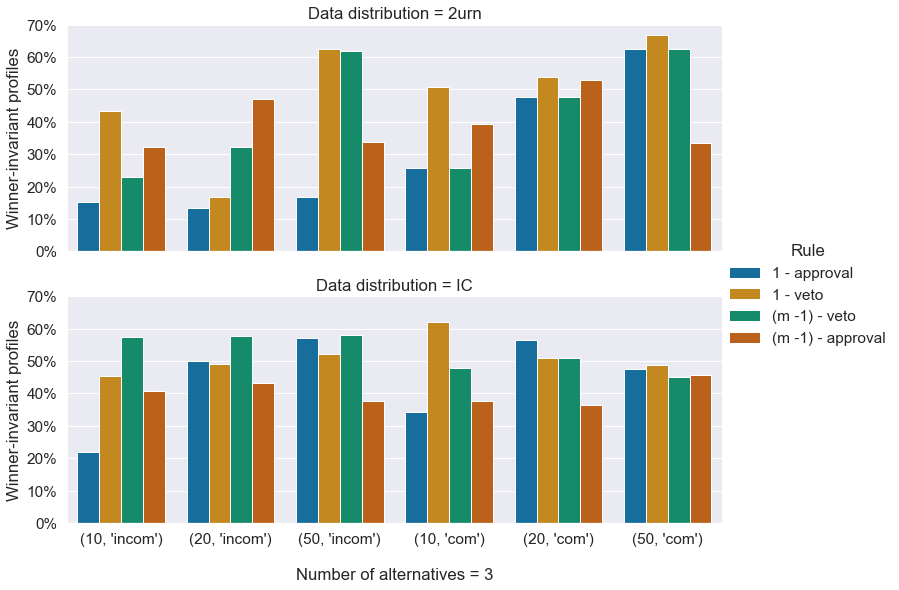

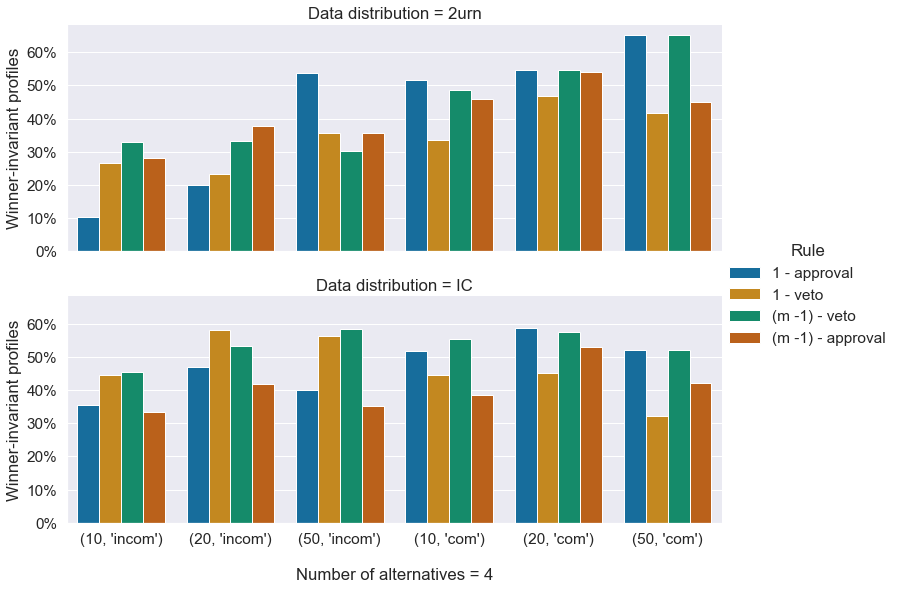

In [36]:
for num_alt_to_show in [3, 4]:
    dft = df[df['num_alt'] == num_alt_to_show]

    dft = dft.groupby(['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']).apply(
        lambda x: (x['same_winner_times'].mean()) / (x['result'] != 0).sum()).reset_index()

    dft.rename(columns={0: 'Winner-invariant profiles'}, inplace=True)
    dft['Winner-invariant profiles'] = dft['Winner-invariant profiles'] * 100
    dft.rename(columns={'data_type': 'Data distribution'}, inplace=True)
    dft['Rule'] = dft.apply(lambda row: (f'{row["k"].replace("num_alt-1", "(m -1)")} - {row["method"]}'), axis=1)
    dft[f'\nNumber of alternatives = {num_alt_to_show}'] = dft.apply(
        lambda row: (row["num_vot"], {True: 'com', False: 'incom'}[row["completeness"]]), axis=1)
    sns.set(font_scale=1.4)
    g = sns.catplot(x=f'\nNumber of alternatives = {num_alt_to_show}',
                    y='Winner-invariant profiles',
                    hue="Rule",
                    row='Data distribution',
                    data=dft,
                    kind="bar",
                    order=[(10, 'incom'), (20, 'incom'), (50, 'incom'), (10, 'com'), (20, 'com'), (50, 'com')],
                    hue_order=['1 - approval', '1 - veto', '(m -1) - veto', '(m -1) - approval'],
                    height=4, aspect=2.5, palette='colorblind')

    for ax in g.axes.flat:
        ylabels = [str(int(x)) + '%' for x in ax.get_yticks()]
        ax.set_yticklabels(ylabels)